# Final Project MHPC 2019-2020

In [132]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import *
from scipy.integrate import *

The Allen–Cahn equation (after John W. Cahn and Sam Allen) is a reaction–diffusion equation of mathematical physics which describes the process of phase separation in multi-component alloy systems, including order-disorder transitions.

The equation describes the time evolution of a scalar-valued state variable $\eta$  on a domain $\Omega=[0,1]$  during a time interval $[0,T]$, and is given (in one dimension) by:

$$
\frac{\partial \eta}{\partial t} - \varepsilon^2 \eta'' + f'(\eta) = 0, \qquad \eta'(0, t) = \eta'(1, t) = 0,\qquad\eta(x,0) = \eta_0(x)
$$

where $f$ is a double-well potential, $\eta_0$ is the initial condition, and $\varepsilon$ is the characteristic width of the phase transition.

This equation is the L2 gradient flow of the Ginzburg–Landau free energy functional, and it is closely related to the Cahn–Hilliard equation.

A typical example of double well potential is given by the following function

$$
f(\eta) = \eta^2(\eta-1)^2
$$

which has two minima in $0$ and $1$ (the two wells, where its value is zero), one local maximum in $0.5$, and it is always greater or equal than zero.

The two minima above behave like "attractors" for the phase $\eta$. Think of a solid-liquid phase transition (say water+ice) occupying the region $[0,1]$. When $\eta = 0$, then the material is liquid, while when $\eta = 1$ the material is solid (or viceversa).

Any other value for $\eta$ is *unstable*, and the equation will pull that region towards either $0$ or $1$.

Discretisation of this problem can be done by finite difference in time. For example, a fully explicity discretisation in time would lead to the following algorithm.

We split the interval $[0,T]$ in `n_steps` intervals, of dimension `dt = T/n_steps`. Given the solution at time `t[k] = k*dt`, it i possible to compute the next solution at time `t[k+1]` as

$$
\eta_{k+1} = \eta_{k} + \Delta t \varepsilon^2 \eta_k'' - \Delta t f'(\eta_k)
$$

Such a solution will not be stable. A possible remedy that improves the stability of the problem, is to treat the linear term $\Delta t \varepsilon^2 \eta_k''$ implicitly, and keep the term $-f'(\eta_k)$ explicit, that is:

$$
\eta_{k+1} - \Delta t \varepsilon^2 \eta_k'' = \eta_{k} - \Delta t f'(\eta_k)
$$

Grouping together the terms on the right hand side, this problem is identical to the one we solved in the python notebook number 9, with the exception of the constant $\Delta t \varepsilon^2$ in front the stiffness matrix.

In particular, given a set of basis functions $v_i$, representing $\eta = \eta^j v_j$ (sum is implied), we can solve the problem using finite elements by computing

$$
\big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) \eta^j_{k+1} = \big((v_i, v_j) \eta^j_{k} - \Delta t (v_i, f'(\eta_k)\big)
$$
where a sum is implied over $j$ on both the left hand side and the right hand side. Let us remark that while writing this last version of the equation we moved from a forward Euler scheme to a backward Euler scheme for the second spatial derivative term: that is, we used $\eta^j_{k+1}$ instead of $\eta^j_{k}$.  

This results in a linear system

$$
A x = b
$$

where 

$$
A_{ij} = M_{ij}+ \Delta t \varepsilon^2 K_{ij} = \big((v_i, v_j) + \Delta t \varepsilon^2  (v_i', v_j')\big) 
$$

and 

$$
b_i = M_{ij} \big(\eta_k^j - \Delta t f'(\eta_k^j)\big)
$$

where we simplified the integration on the right hand side, by computing the integral of the interpolation of $f'(\eta)$.

## Step1

Write a finite element solver, to solve one step of the problem above, given the solution at the previous time step, using the same techniques used in notebook number 9.

In particular:

1. Write a function that takes in input a vector representing $\eta$, an returns a vector containing $f'(\eta)$. Call this function `F`.

2. Write a function that takes in input a vector of support points of dimension `ndofs` and the degree `degree` of the polynomial basis, and returns a list of basis functions (piecewise polynomial objects of type `PPoly`) of dimension `ndofs`, representing the interpolatory spline basis of degree `degree`

3. Write a function that, given a piecewise polynomial object of type `PPoly` and a number `n_gauss_quadrature_points`, computes the vector of global_quadrature_points and global_quadrature_weights, that contains replicas of a Gauss quadrature formula with `n_gauss_quadrature_points` on each of the intervals defined by `unique(PPoly.x)`

4. Write a function that, given the basis and the quadrature points and weights, returns the two matrices $M$ and $K$ 

#### 1.

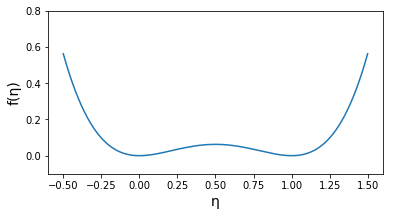

In [133]:
#doube well potential function
def f(eta):
    return eta * eta * (eta - 1)**2 

plt.figure(figsize = (6,3))
_ = plt.plot(np.linspace(-0.5,1.5,1025), f(np.linspace(-0.5,1.5, 1025)))
_ = plt.xlabel("\u03B7", fontsize = 14)
_ = plt.ylabel("f(\u03B7)", fontsize = 14)
_ = plt.ylim((-0.1, 0.8))

In [134]:
# First derivative of the double-well potential function
def F(eta):
    return 2.*eta*(eta - 1)**2 + 2.*(eta - 1)*eta**2

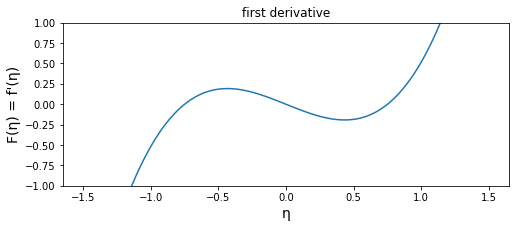

In [135]:
plt.figure(figsize = (8,3))
_ = plt.plot(np.linspace(-1.5,1.5,1025), F(np.linspace(-0.5,1.5,1025)))
_ = plt.xlabel("\u03B7", fontsize = 14)
_ = plt.ylabel("F(\u03B7) = f'(\u03B7)", fontsize = 14)
_ = plt.title("first derivative")
_ = plt.ylim((-1, 1))

#### 2. 
The combination of the functions splrep and PPoly.from_spline can be used to construct a piecewise polynomial objects, for which we can evaluate the value and all the derivatives at arbitrary points.

The basis functions are constructed from the spline interpolation by computing the piecewise interpolation of a function that has value one in one of the support points `q[i]` and zero in all other support points.
Such function is unique, there are `M` of them, and they define a basis for a piecewise polynomial space of dimension `M`.

In [136]:
def basis_func(ndofs, degree):
    basis = []
    for i in range(len(ndofs)):
        c = ndofs*0 # array of dim M
        c[i] = 1 # at each step of the cycle i create an array wich take 1 in poi i*1/M
        bi = PPoly.from_spline(splrep(ndofs, c, k = degree)) # create a polinomy of degree =1
        basis.append(bi)
    
    return basis

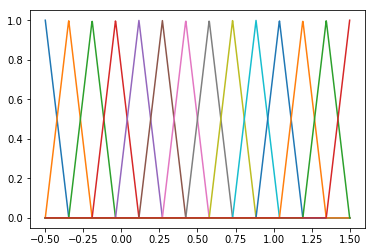

In [137]:
N = 1025
M = 14
x = np.linspace( -0.5, 1.5 , N) # N punti in [0,1]
q = np.linspace(-0.5, 1.5, M) # M punti in [0,1]
yq = f(q) # f_k, k=0, M-1

B = np.zeros((N,M)) #NXM matrix of zero

for i in range(M):
    B[:,i] = basis_func( q, 1)[i](x) # (1<=k<=5)
_ = plt.plot(x,B)


#plt.plot(x, f(x))
#plt.plot(q, yq, 'ro')
#plt.plot(x, B.dot(f(q)) )

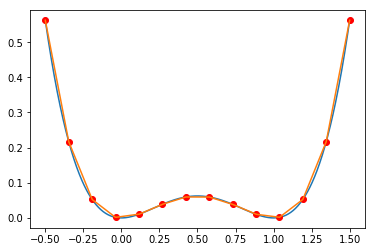

In [138]:
plt.plot(x, f(x))
plt.plot(q, yq, 'ro')
plt.plot(x, B.dot(f(q)))

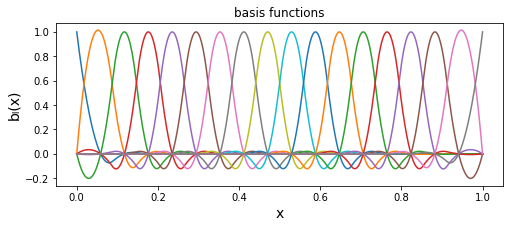

In [139]:
#Basis functions for ndofs = 20 and degree = 2
plt.figure(figsize = (8,3))
for i in range(18):
    _ = plt.plot( np.linspace(0,1,1025), basis_func(np.linspace(0,1,18),2)[i]( np.linspace(0,1,1025) ) )
    
_ = plt.xlabel("x", fontsize = 14)
_ = plt.ylabel("b\u2097(x)", fontsize = 14)
_ = plt.title("basis functions")

In [140]:
basis = basis_func( q, 5) # (1<=k<=5)
np.unique(basis[1].x)

array([-0.5       , -0.03846154,  0.11538462,  0.26923077,  0.42307692,
        0.57692308,  0.73076923,  0.88461538,  1.03846154,  1.5       ])

#### 3.

In [141]:
def global_quadr_weight( basis, n_gauss_quadrature_points):
    
    intervals = np.unique(basis[0].x)

    qp, w = np.polynomial.legendre.leggauss(n_gauss_quadrature_points)
    
    # for polynomials of degree 2*n_gauss_quadrature_points - 1 or less
    # rescale points, weights to work in the interval [0,1] rather than [-1,1]
    
    qp = (qp+1)/2
    w /= 2

    h = np.diff(intervals)
    global_quadrature = np.array([intervals[i]+h[i]*qp for i in range(len(h))]).reshape((-1,))
    global_weights = np.array([w*h[i] for i in range(len(h))]).reshape((-1,))
    
    return global_quadrature, global_weights


In [142]:
degree = 1
q = np.linspace(0, 1, 16) # M punti in [0,1]
basis = basis_func( q, degree)    
global_quadrature, global_weights = global_quadr_weight( basis, degree + 1)
#global_quadrature

#### 4.

In [143]:
# given the basis and the quadrature points and weights, returns the two matrices M and K:
# M_ij = (v_i, v_j) and K_ij = (v_i', v_j')

def system_matrices(basis, global_quadrature, global_weights):
    
    dbasis = [bi.derivative(1) for bi in basis]
    
    Bq = np.array([basis[i](global_quadrature) for i in range(len(basis))]).T
    dBq = np.array([dbasis[i](global_quadrature) for i in range(len(basis))]).T
    
    # return M, K
    return np.einsum('qi, q, qj', Bq, global_weights, Bq), np.einsum('qi, q, qj', dBq, global_weights, dBq)

## Step2
Solve the Allen-Cahan equation on the interval $[0,1]$, from time $t=0$ and time $t=1$, given a time step `dt`, a number of degrees of freedom `ndofs`, and a polynomial degree `k`.

1. Write a function that takes the initial value of $\eta_0$ as a function, eps, dt, ndofs, and degree, and returns a matrix of dimension `(int(T/dt), ndofs)`  containing all the coefficients $\eta_k^i$ representing the solution, and the set of basis functions used to compute the solution.

2. Write a function that takes all the solutions `eta`, the basis functions, a stride number `s`, and a resolution `res`, and plots on a single plot the solutions $\eta_0$, $\eta_s$, $\eta_{2s}$, computed on `res` equispaced points between zero and ones.

#### 1.

In [144]:
# Numerically solve Allen-Cahan
def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    
    support_points = np.linspace(0,1,ndofs)
    
    basis = basis_func(support_points, degree)
    
    global_q, global_w=global_quadr_weight(basis, degree + 1)
    
    M, K = system_matrices(basis, global_q, global_w)
    
    T = 1.0  # time domain: [0, T]; here T = 1.0
    
    eta = np.zeros((int(T/dt) + 1, ndofs))
    
    A = M + eps*eps*dt*K
    
    eta_now = eta_0_function(support_points)
    
    eta[0,:] = eta_now
    
    for i in range(1, int(T/dt) + 1):
    
        b = M.dot(eta_now - dt * F(eta_now))
                   
        eta_later = np.linalg.solve(A, b)
                     
        eta[i,:] = eta_later
                   
        eta_now = eta_later
                   
    return eta, basis

#### 2.

In [145]:

def plot_solution(eta, basis, stride, res, legend = False, title = ""):

    x = np.linspace(0,1,res)
    
    B = np.zeros((res, len(basis)))
    
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
        
    eta_plot = eta[::stride].dot(B.T)
    
    T = 1.0  # time domain: [0, T]; here T = 1.0
    
    for i in range(eta_plot.shape[0]):
        plt.plot(x, eta_plot[i,:], label = "t = " + str(i*stride*T/(eta.shape[0]-1)))
        
    plt.xlabel("x", fontsize = 14)
    plt.ylabel("\u03B7\u209C(x)", fontsize = 14)
    plt.title("solution \u03B7\u209C(x)" + title)
    
    if (legend == True):
        plt.legend()

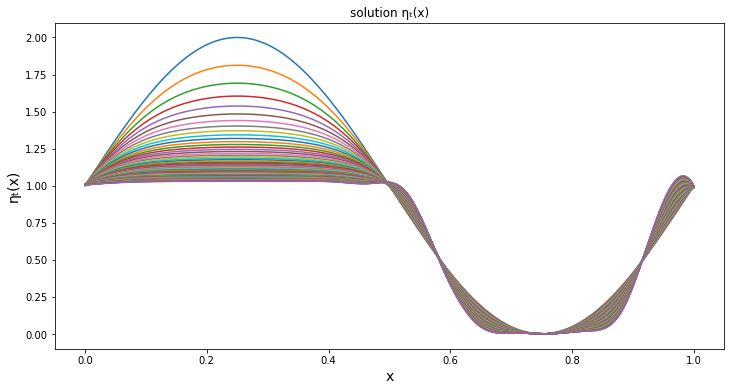

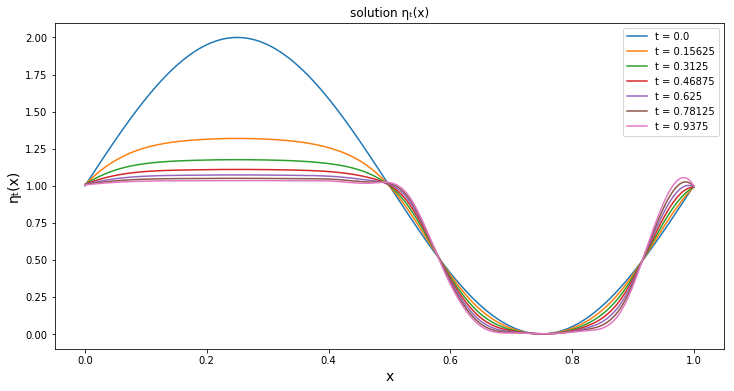

In [146]:
def eta_0_function(x):
    return np.sin(2.*np.pi*x) + 1.

eps = 0.01
dt = 0.015625
ndofs = 18
degree = 3

eta, basis = solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree)

stride = 1
res = 1025

plt.figure(figsize = (12,6))
plot_solution(eta, basis, stride, res)

stride = 10

plt.figure(figsize = (12,6))
plot_solution(eta, basis, stride, res, legend = True)


## Step3

I report the final solution for all the combinations of the following parameters at $t=1$ :

1. eps = [01, .001]

2. ndofs = [16, 32, 64, 128]

3. degree = [1, 2, 3]

3. dt = [.25, .125, .0625, .03125, .015625]

with $\eta_0 = \sin(2 \pi x)+1$.

In [147]:
def plot_solution_final(eta, basis, res, initial = False, title = ""):
    # plot eta[-1,:], on x = linspace(0,1,resolution)
    x = np.linspace(0,1,res)
    B = np.zeros((res, len(basis)))
    
    for i in range(len(basis)):
        B[:,i] = basis[i](x)
        
    plt.plot(x, eta[-1,:].dot(B.T), label = "t = 1", color='indigo')
        
    if (initial == True):
        plt.plot(x, eta[0,:].dot(B.T), label = "t = 0", color='fuchsia')    
        
    plt.legend()
    plt.xlabel("x", fontsize = 10)
    plt.ylabel("\u03B7\u209C(x)", fontsize = 10)
    plt.title("solution \u03B7\u209C(x)" + title)

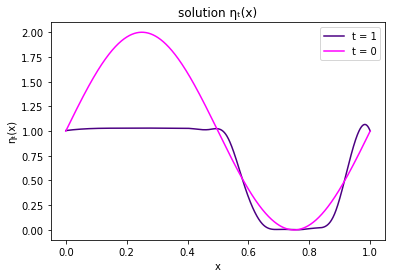

In [148]:
plot_solution_final(eta, basis, res, True)

In [149]:
def solutions(eps, degree, res, initial = False):
    dt = [.25, .125, .0625, .03125, .015625]
    ndofs = [16, 32, 64, 128]
    
    print("\033[1m SOLUTION AT eps = " + str(eps) + ", degree = " + str(degree) + " \033[0m \n")

    plt.figure(figsize = (20,18))

    for i in range(len(dt)):
        for j in range(len(ndofs)):
            
            eta, basis = solve_allen_cahan(eta_0_function, eps, dt[i], ndofs[j], degree)
            
            plt.subplot(len(dt), len(ndofs), int(len(ndofs)*i + j + 1))
            plot_solution_final(eta, basis, resolution, initial = initial, title = " at dt = " + str(dt[i]) + ", ndofs = " + str(ndofs[j]))
        
    plt.tight_layout()

 SOLUTION AT eps = 0.01, degree = 1  



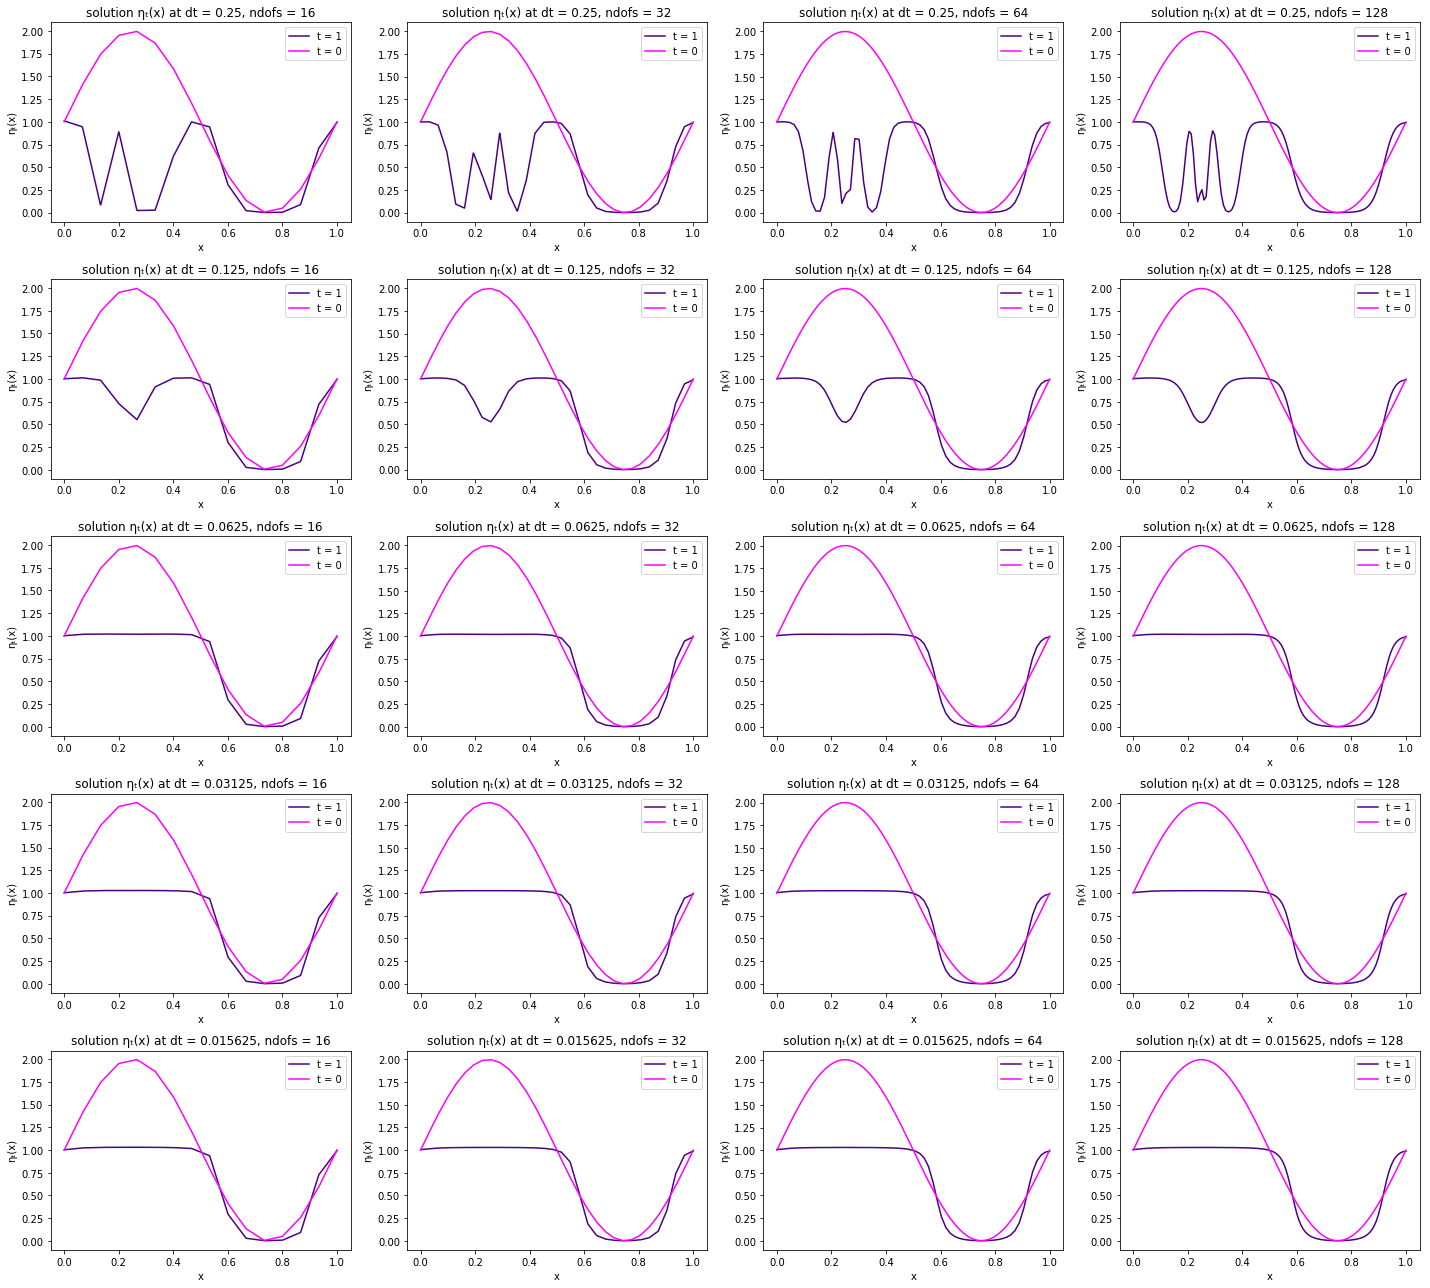

In [150]:
eps = 0.01
degree = 1
resolution = 1025
solutions(eps, degree, resolution, initial = True)

 SOLUTION AT eps = 0.001, degree = 1  



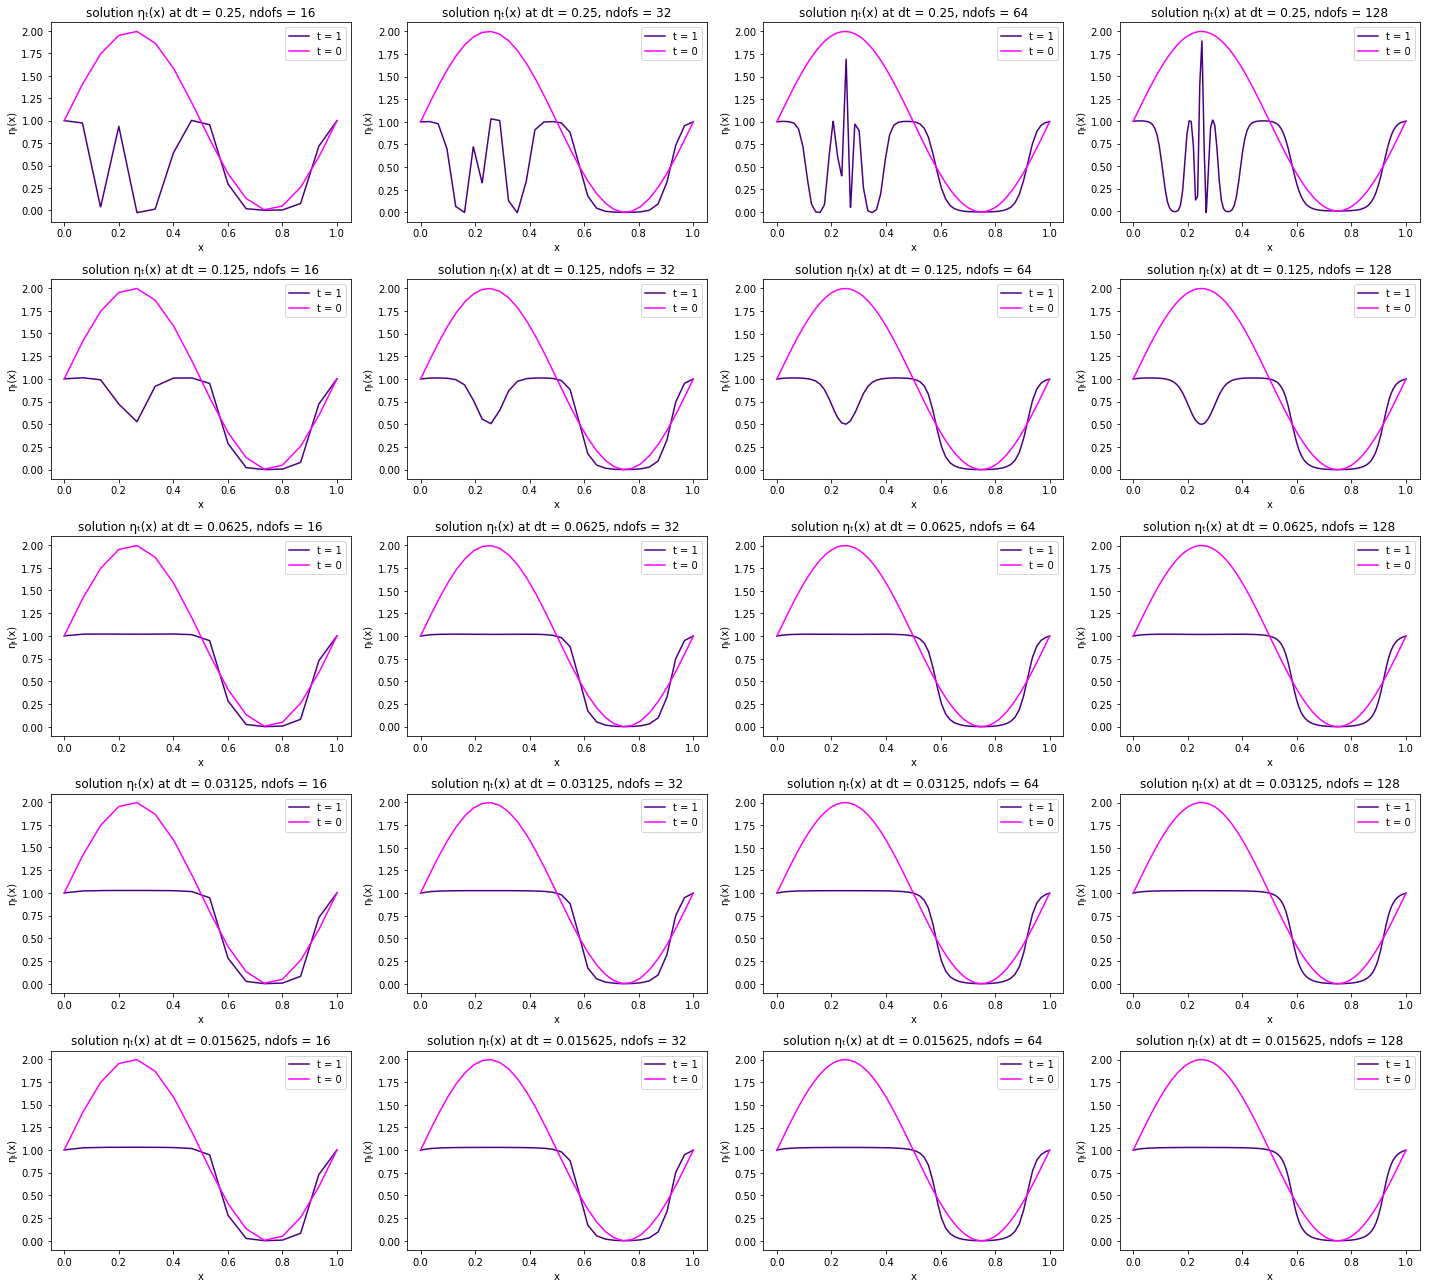

In [151]:
eps = 0.001
degree = 1
resolution = 1025
solutions(eps, degree, resolution, initial = True)

 SOLUTION AT eps = 0.01, degree = 2  



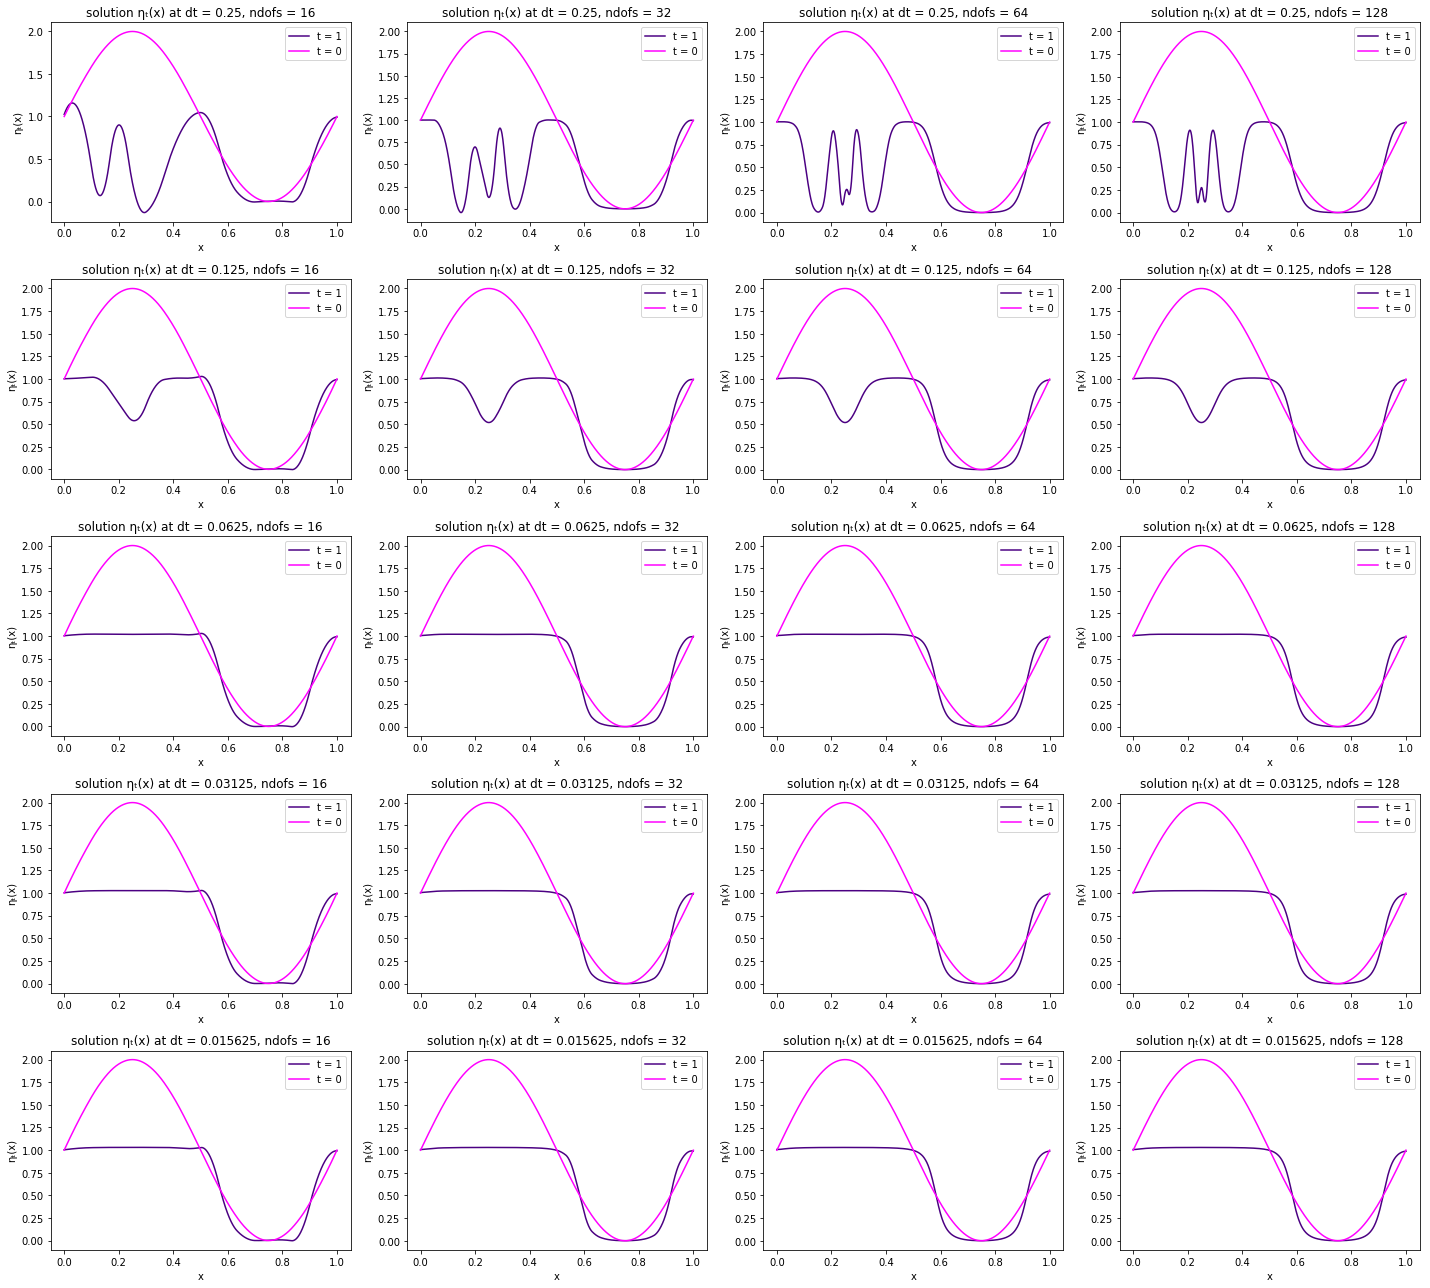

In [152]:
eps = 0.01
degree = 2
resolution = 1025

solutions(eps, degree, resolution, initial = True)

 SOLUTION AT eps = 0.001, degree = 2  



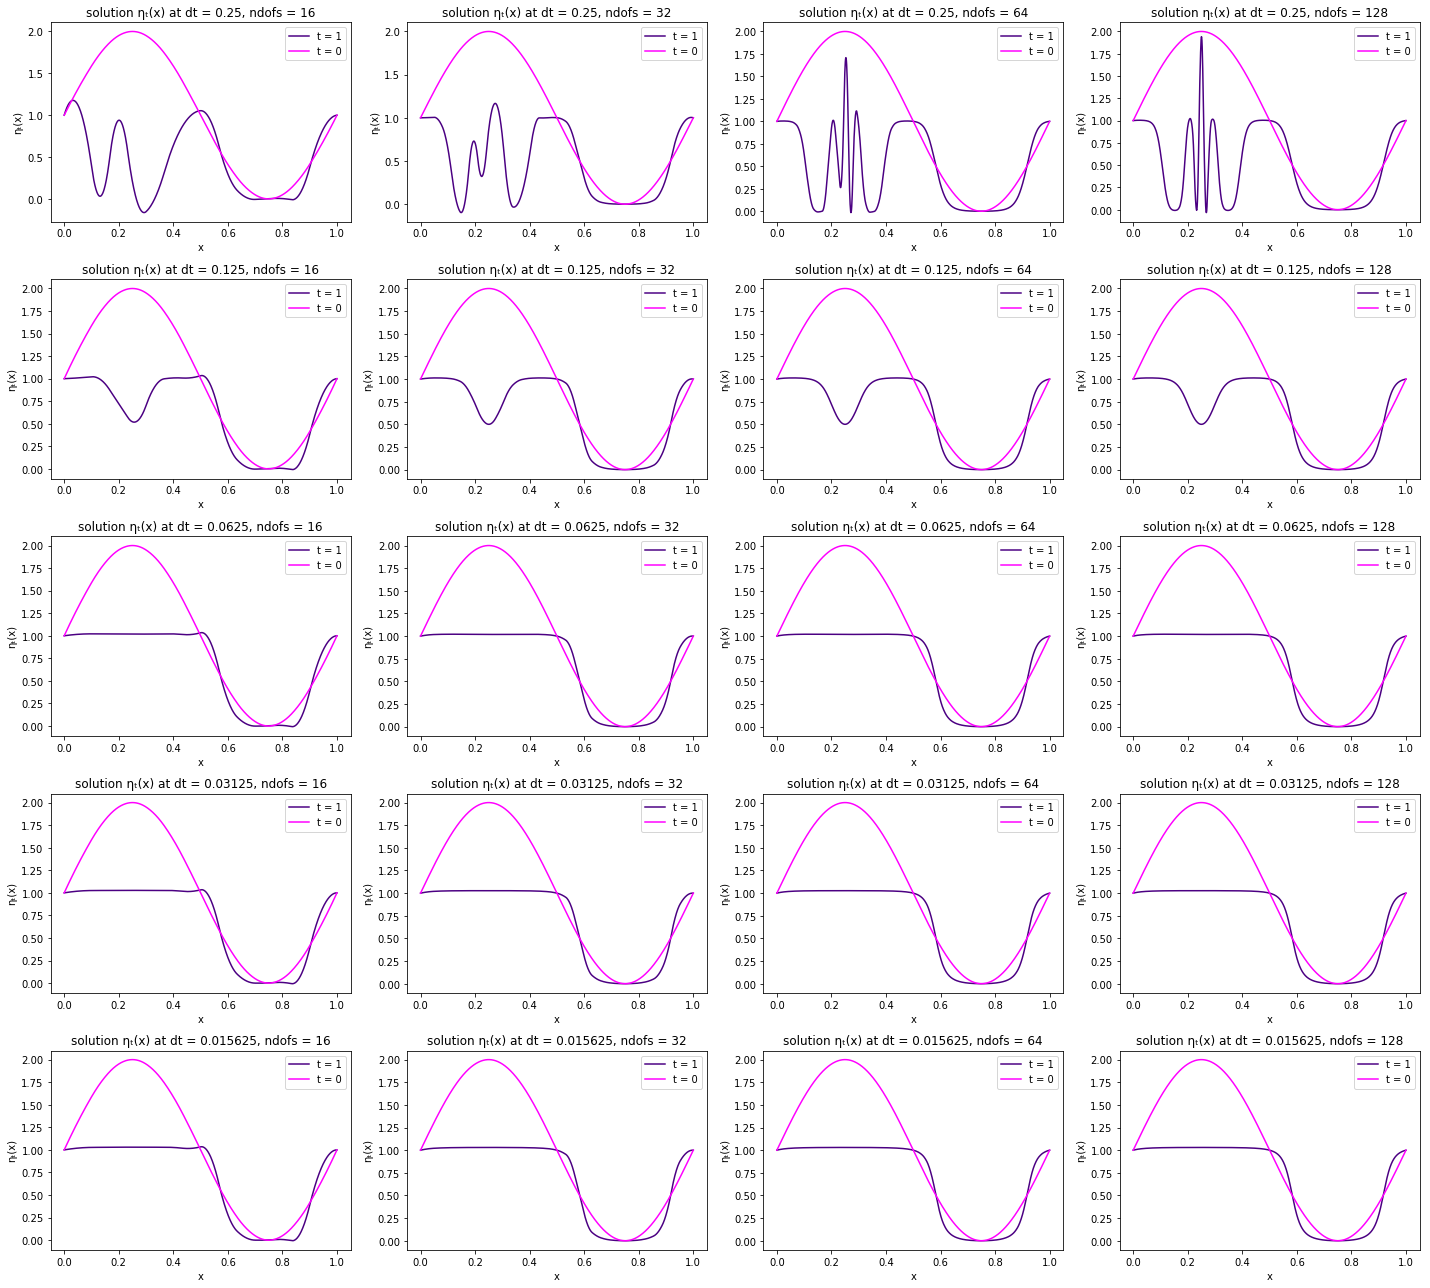

In [153]:
eps = 0.001
degree = 2
resolution = 1025

solutions(eps, degree, resolution, initial = True)

 SOLUTION AT eps = 0.01, degree = 3  



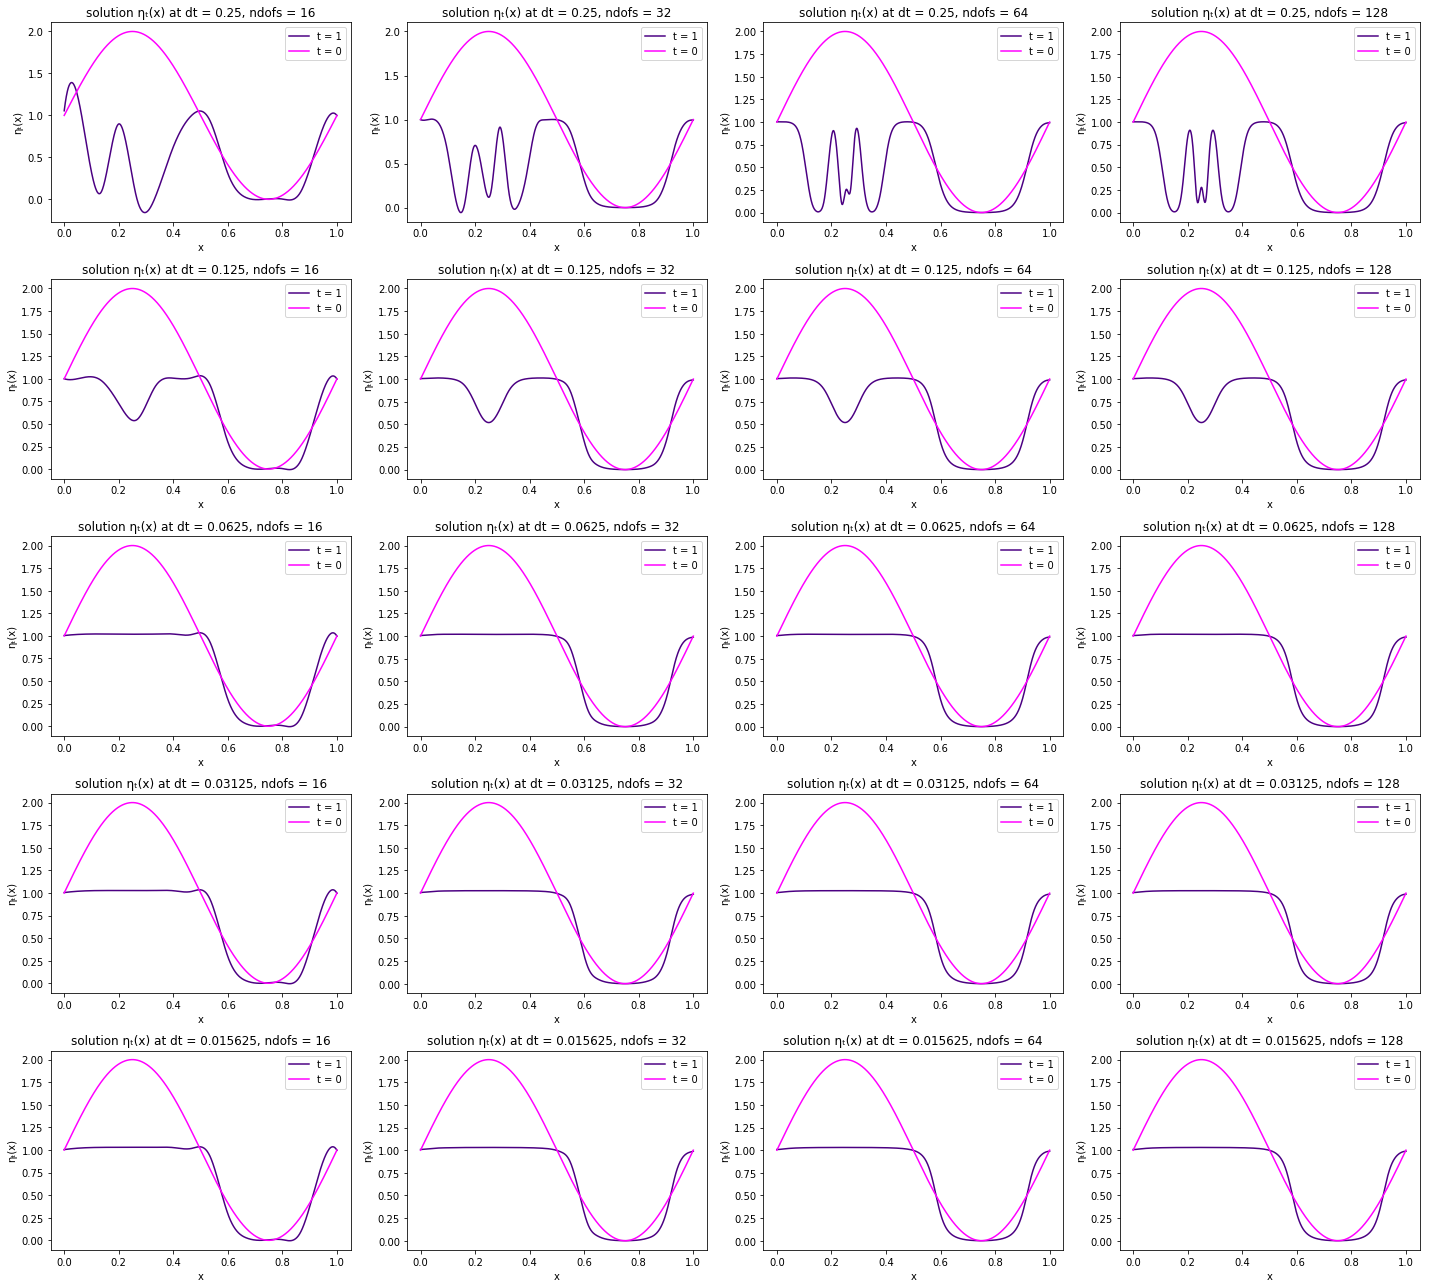

In [154]:
eps = 0.01
degree = 3
resolution = 1025

solutions(eps, degree, resolution, initial = True)

 SOLUTION AT eps = 0.001, degree = 3  



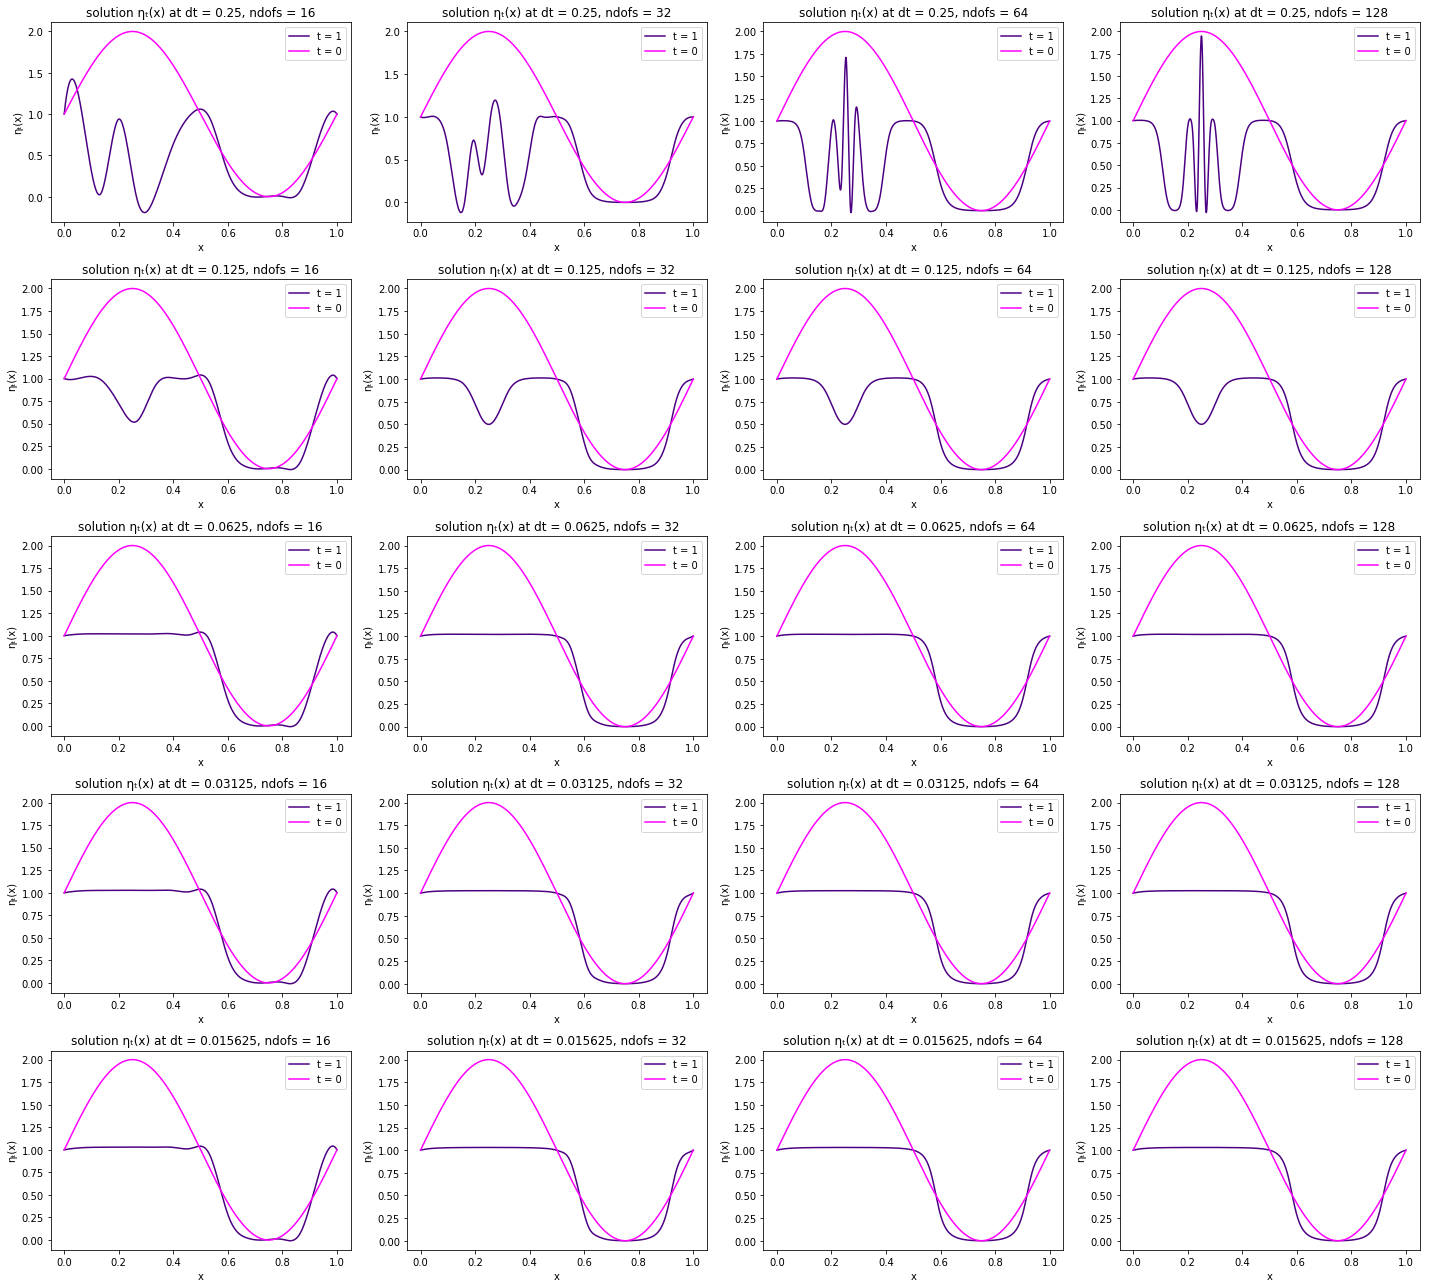

In [155]:
eps = 0.001
degree = 3
resolution = 1025

solutions(eps, degree, resolution, initial = True)

In [156]:
#What do you observe? What happens when you increase ndofs and keep dt constant? 

The numerical solution (at least for small $\Delta t$) correctly tends to the expected solution given our potential: $1$ for $\eta > 0.5$, $0$ for $\eta < 0.5$.

If we increase the number of degrees of freedom while keeping $\Delta t$ constant, the final solution gets smoother. 

The solution gets smoother also when increasing the degree of th epolynomial basis.

For large $\Delta t$ the solution does not always converge: this is because the forward Euler method is not stable for all range of parameters and also because time derivative approximations become less precise for large $\Delta t$.